In [1]:
%%time
%run theory_basics.ipynb

CPU times: user 5min 51s, sys: 14min 52s, total: 20min 43s
Wall time: 2min 17s


In [2]:
%run dream_basics.ipynb

In [3]:
matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rc('text', usetex=True)

In [4]:
def plot_activity(X, t, bins=20, cutoff_div=None):
    if cutoff_div is not None:
        data = np.array_split(
            np.concatenate([X[: len(X) // cutoff_div + 2], X[-len(X) // cutoff_div :]]),
            bins,
            axis=0,
        )
        t_data = np.array_split(
            np.concatenate([t[:len(X) // cutoff_div + 2], t[-len(X) // cutoff_div :]]),
            bins
        )
    else:
        data = np.array_split(X, bins, axis=0)
        t_data = np.array_split(t, bins)

    # Create a figure with subplots
    fig, axs = plt.subplots(1, bins, figsize=(12, 4), sharey=False)

    # Iterate over the subplots and plot the corresponding data
    for i, ax in enumerate(axs):
        ax.imshow(data[i][::], vmax=X.max(), vmin=X.min(),
                  #extent=[0, 20, 2*N, 0])
                  extent=[0, N/len(data[i])*(t_data[i][-1]-t_data[i][0]), t_data[i][-1], t_data[i][0]])
        ax.set_xticks([])
        ax.set_xlabel('$x$')
    axs[0].set_ylabel("time (s)", fontsize=15)
    plt.subplots_adjust(wspace=-0.2)
    plt.tight_layout()
    plt.show()

In [16]:
def plot_activity2(X, t, bins=20, cutoff_div=None):
    if cutoff_div is not None:
        data = np.array_split(
            np.concatenate([X[: len(X) // cutoff_div + 2], X[-len(X) // cutoff_div :]]),
            bins,
            axis=0,
        )
        t_data = np.array_split(
            np.concatenate([t[:len(X) // cutoff_div + 2], t[-len(X) // cutoff_div :]]),
            bins
        )
    else:
        data = np.array_split(X, bins, axis=0)
        t_data = np.array_split(t, bins)

    # Create a figure with subplots
    fig, axs = plt.subplots(bins, 1, figsize=(10, 7), sharey=False)

    # Iterate over the subplots and plot the corresponding data
    for i, ax in enumerate(axs):
        im_data = ax.imshow(data[i][::].T, vmax=1, vmin=0,
                              #extent=[0, 20, 2*N, 0])
                              extent=[t_data[i][0], t_data[i][-1], 0, N/len(data[i])*(t_data[i][-1]-t_data[i][0])])
        ax.set_yticks([])
        ax.set_ylabel('$x$', fontsize=14)
    axs[-1].set_xlabel("t (seconds)", fontsize=15)
    plt.subplots_adjust(hspace=-0.7)
    cax = fig.add_axes([1.025, 0.105, 0.0125, 0.75])
    plt.colorbar(im_data, cax=cax)
    plt.tight_layout()
    plt.savefig('../latex/images/long_term_replay.pdf', bbox_inches='tight')
    plt.show()

In [6]:
simulation_duration_dream = 300 * T
t_dream = np.arange(0, simulation_duration_dream, dt)

In [7]:
X_dream, w_dream, W_dream, DW_dream, DX_dream = simulate(
    dt,
    N,
    T,
    t_dream,
    theta,
    alpha,
    beta,
    delay_i,
    lmbda,
    w.copy(),
    get_dw_prime_mean,
    get_dx,
    f_I_conv_circ_fft,
    phi,
    u,
    stimulate=False,
    full_info=True,
    init_steps=2*N
)

/tmp/ipykernel_19717/2718116194.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


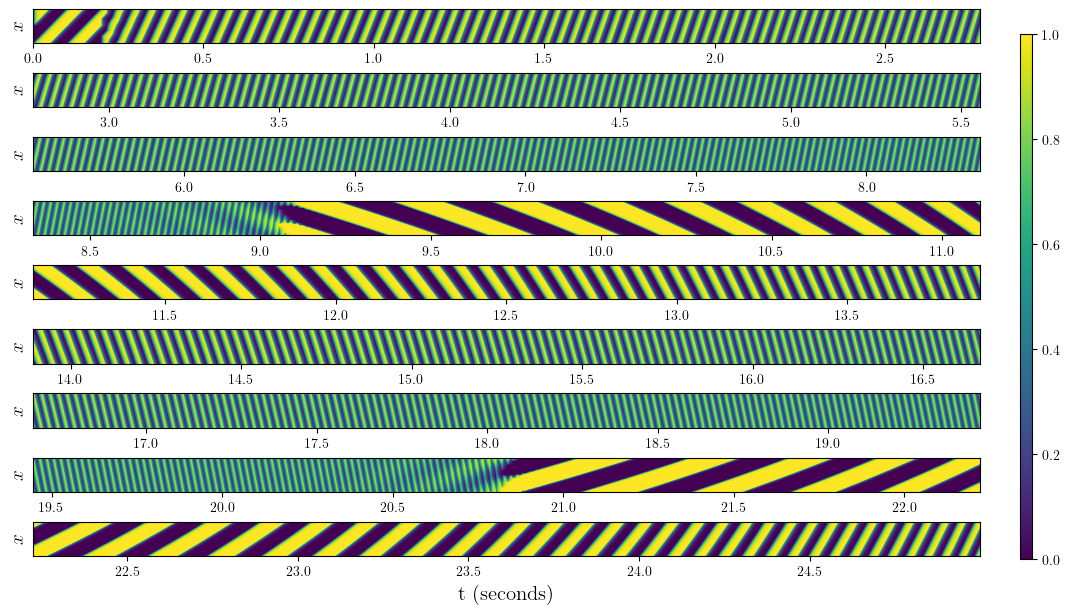

In [17]:
plot_activity2(X_dream[:250*N], t_dream[:250*N], bins=9, cutoff_div=None)

In [11]:
def rolling_average(data, window_size):
    """Computes the rolling average of the given data with specified window size."""
    cumsum_vec = np.cumsum(np.insert(data, 0, 0)) 
    return (cumsum_vec[window_size:] - cumsum_vec[:-window_size]) / window_size

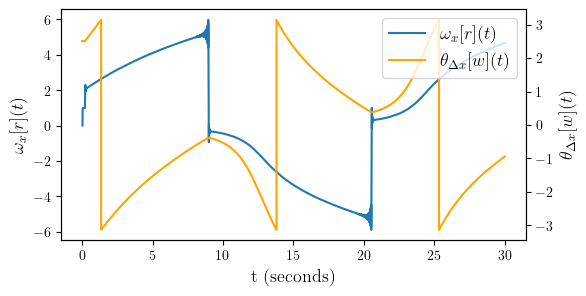

In [201]:
plt.figure(figsize=(6, 3))

# Create the first axis
ax1 = plt.gca()
line1, = ax1.plot(t_dream[150:], rolling_average(to_theta(get_angles(X_dream[1:]) - get_angles(X_dream[:-1])), 150)/dt/2/np.pi/10, label=r'$\omega_x[r](t)$')
ax1.set_xlabel('t (seconds)', fontsize=13)
ax1.set_ylabel(r'$\omega_x[r](t)$', fontsize=13)  # Update with appropriate label

# Create the second axis
ax2 = ax1.twinx()
line2, = ax2.plot(t_dream[:], get_angles(W_dream), c='orange', label=r'$\theta_{\Delta x}[w](t)$')
ax2.set_ylabel(r'$\theta_{\Delta x}[w](t)$', fontsize=13)  # Update with appropriate label

# Collecting handles and labels for the unified legend
handles, labels = [], []
for ax in [ax1, ax2]:
    for handle, label in zip(*ax.get_legend_handles_labels()):
        handles.append(handle)
        labels.append(label)

# Creating one unified legend
plt.legend(handles, labels, loc='upper right', fontsize=13)

plt.show()

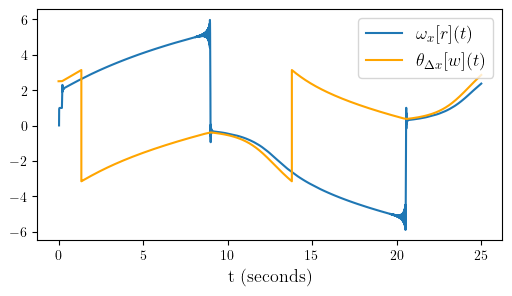

In [209]:
plt.figure(figsize=(6, 3))
plt.plot(t_dream[150:250*N], rolling_average(to_theta(get_angles(X_dream[1:250*N]) - get_angles(X_dream[:250*N-1])), 150)/dt/2/np.pi/10, label=r'$\omega_x[r](t)$')
plt.plot(t_dream[:250*N], get_angles(W_dream[:250*N]), c='orange', label=r'$\theta_{\Delta x}[w](t)$')
plt.xlabel('t (seconds)', fontsize=13)
plt.legend(loc='upper right', fontsize=13)

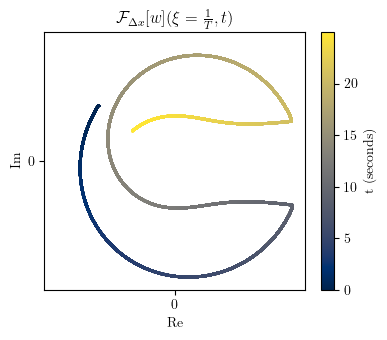

In [8]:
plt.figure(figsize=(4, 3.5))
W_fft = np.fft.fft(W_dream, axis=1)[:250*N, 1]
scatter = plt.scatter(W_fft.real, W_fft.imag, c=t_dream[:250*N], s=1, cmap=plt.cm.cividis)
plt.title(r'$\mathcal{F}_{\Delta x}[w](\xi=\frac{1}{T}, t)$')
plt.xlabel('Re')
plt.ylabel('Im')
cbar = plt.colorbar(scatter)
cbar.set_label('t (seconds)')
plt.xticks([0])
plt.yticks([0])
plt.xlim(-200, 200)
plt.ylim(-200, 200)
plt.tight_layout()

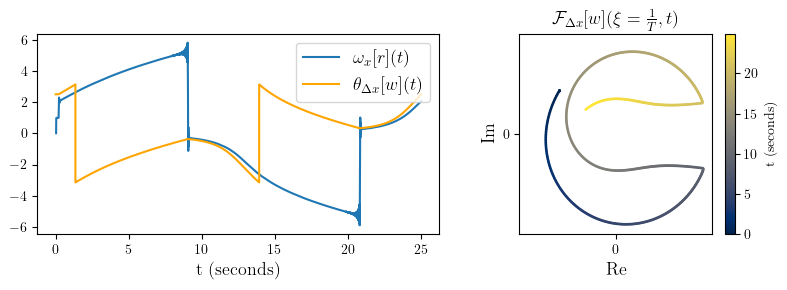

In [12]:
# Create a figure with custom subplot sizes
fig = plt.figure(figsize=(8, 3))  # Adjust the total figure size as needed
ax1 = fig.add_subplot(1, 5, (1, 3))  # First two-thirds for the first plot
ax2 = fig.add_subplot(1, 5, (4, 5))       # Last third for the second plot

# First plot on the left
ax1.plot(t_dream[150:250*N], rolling_average(to_theta(get_angles(X_dream[1:250*N]) - get_angles(X_dream[:250*N-1])), 150)/dt/2/np.pi/10, label=r'$\omega_x[r](t)$')
ax1.plot(t_dream[:250*N], get_angles(W_dream[:250*N]), c='orange', label=r'$\theta_{\Delta x}[w](t)$')
ax1.set_xlabel('t (seconds)', fontsize=13)
ax1.legend(loc='upper right', fontsize=13)

# Second plot on the right
W_fft = np.fft.fft(W_dream, axis=1)[:250*N:200, 1]
scatter = ax2.scatter(W_fft.real, W_fft.imag, c=t_dream[:250*N:200], s=1, cmap=plt.cm.cividis)
ax2.set_title(r'$\mathcal{F}_{\Delta x}[w](\xi=\frac{1}{T}, t)$', fontsize=13)
ax2.set_xlabel('Re', fontsize=13)
ax2.set_ylabel('Im', fontsize=13)
cbar = fig.colorbar(scatter, ax=ax2)
cbar.set_label('t (seconds)')
ax2.set_xticks([0])
ax2.set_yticks([0])
ax2.set_xlim(-200, 200)
ax2.set_ylim(-200, 200)

# Adjust layout for a tight fit
plt.tight_layout(w_pad=3)

plt.savefig('../latex/images/long_term_replay_phases.pdf', bbox_inches='tight')
# To display the plot
plt.show()

In [14]:
def plot_system_segment(start, end, X, W, t):
    plt.figure(figsize=(8.5, 3))
    gs = plt.GridSpec(1, 4, width_ratios=[1.5, 2, 2, 0.1])
    ax1 = plt.subplot(gs[0, 0])
    ax1.imshow(X[start:end], extent=[0, N/(end-start)*(t[end]-t[start]), t[end], t[start]])
    ax1.set_ylabel('t (seconds)')
    ax1.set_xticks([0, T], [r'$0$', r'$T$'])
    ax1.set_xlabel('$x$')
    ax1.set_title(r'$r(x, t)$')
    ax2 = plt.subplot(gs[0, 1])
    X_fft = np.fft.fft(X, axis=1)[:, 1]
    ax2.scatter(X_fft.real[start:end], X_fft.imag[start:end], c=t[start:end], s=1, cmap=plt.cm.cividis)
    ax2.set_xlabel('Re')
    ax2.set_ylabel('Im', labelpad=-3)
    ax2.set_xlim(-200, 200)
    ax2.set_ylim(-200, 200)
    ax2.set_title(r'$\mathcal{F}_{x}[r](\xi=\frac{1}{T}, t)$')
    ax3 = plt.subplot(gs[0, 2])
    W_fft = np.fft.fft(W, axis=1)[:, 1]
    w_fft_max_h = np.abs(W_fft.real[start:end]).max()+5
    w_fft_max_v = np.abs(W_fft.imag[start:end]).max()+5
    w_fft_max = max(w_fft_max_h, w_fft_max_v)
    scatter = ax3.scatter(W_fft.real[start:end:100], W_fft.imag[start:end:100], c=t[start:end:100], s=1, cmap=plt.cm.cividis)
    ax3.set_xlim(-w_fft_max, w_fft_max)
    ax3.set_ylim(-w_fft_max, w_fft_max)
    ax3.set_xlabel('Re')
    ax3.set_ylabel('Im')
    ax3.set_title(r'$\mathcal{F}_{\Delta x}[w](\xi=\frac{1}{T}, t)$')
    ax3.set_xticks([0])
    ax3.set_yticks([0])
    ax3.set_xlim(-200, 200)
    ax3.set_ylim(-200, 200)
    ax_colorbar = plt.subplot(gs[0, -1])
    cbar = plt.colorbar(scatter, cax=ax_colorbar)
    cbar.set_label('t (seconds)')
    plt.tight_layout()
    plt.savefig('../latex/images/replay_segment.pdf', bbox_inches='tight')
    plt.show()

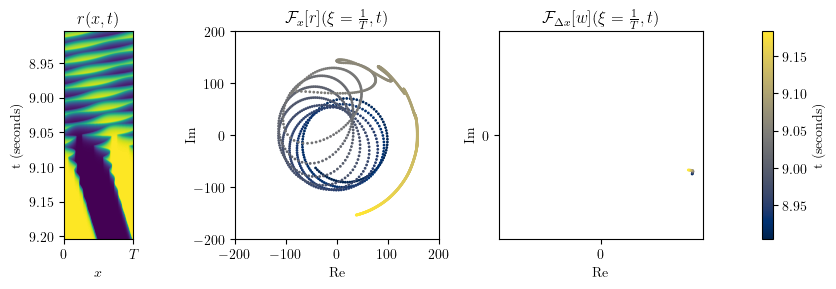

In [23]:
plot_system_segment(44520, 46020, X_dream, W_dream, t_dream)

$$
\mathcal{F}_x\left[\tau_r \frac{\partial}{\partial t} r(x, t)\right]\left(\xi=\frac{1}{T}, t\right) = \tau_r \frac{2 \pi i}{T} \omega_x\left[r\right](t)\mathcal{F}_x\left[r(x, t)\right]\left(\xi=\frac{1}{T}, t\right)
$$

$$
  \mathcal{F}_x\left[r(x, t-\tau_d)\right]\left(\xi=\frac{1}{T}, t\right) = e^{-2\pi i \frac{1}{T} \omega_x\left[r\right](t)\tau_d}\mathcal{F}_x\left[r(x, t)\right]\left(\xi=\frac{1}{T}, t\right).
$$

${\frac{\pi}{2} + 2\pi \xi\tau_d}$

$$
\text{arg}\left(\mathcal{F}_{\Delta x}\left[r(x', t-\tau_d) \star \frac{\partial}{\partial t} {r}(x', t)\right]\left(\xi=\frac{1}{T}, t\right)\right)
$$
$$
= \text{arg}\left(\mathcal{F}_{x}\left[\frac{\partial}{\partial t} r(x, t)\right]\left(\xi=\frac{1}{T}, t\right)\overline{\mathcal{F}_{x}\left[r(x, t-\tau_d)\right]\left(\xi=\frac{1}{T}, t\right)}\right)
$$
$$
= \text{arg}\left(\mathcal{F}_{x}\left[\frac{\partial}{\partial t} r(x, t)\right]\left(\xi=\frac{1}{T}, t\right)\right) - \text{arg}\left({\mathcal{F}_{x}\left[r(x, t-\tau_d)\right]\left(\xi=\frac{1}{T}, t\right)}\right)
$$

$$
= \text{arg}\left(\frac{2 \pi i}{T} \omega_x\left[r\right](t)\mathcal{F}_x\left[r(x, t)\right]\left(\xi=\frac{1}{T}, t\right)\right) - \text{arg}\left(e^{-2\pi i \frac{1}{T} \omega_x\left[r\right](t)\tau_d}\mathcal{F}_x\left[r(x, t)\right]\left(\xi=\frac{1}{T}, t\right)\right)
$$

$$
= \text{arg}(i) + \theta_x[r](t) - \text{arg}(e^{-2\pi i \frac{1}{T}\tau_d \omega_x\left[r\right](t)}) - \theta_x[r](t)
$$

$$
= \frac{\pi}{2} + 2\pi \frac{\tau_d}{T} \omega_x\left[r\right](t)
$$

$$
\tau_w\frac{\partial}{\partial t} w(\Delta x, t) = \frac{1}{T} \int_0^T {r}(x', t-\tau_d)\frac{\partial}{\partial t} {r}(\Delta x + x', t)dx' - \lambda {w}(\Delta x, t)
$$
$$
\frac{1}{T}\left[r(x', t-\tau_d) \star \frac{\partial}{\partial t} {r}(x', t)\right](\Delta x, t) - \lambda {w}(\Delta x, t)
$$

$$
\tau_w\frac{\partial}{\partial t} w(\Delta x, t) = \frac{1}{T}\left[r(x', t-\tau_d) \star \frac{\partial}{\partial t} {r}(x', t)\right](\Delta x, t) - \lambda {w}(\Delta x, t)
$$

$$
\tau_w\mathcal{F}_{\Delta x}\left[\frac{\partial w}{\partial t}\right]\left(\xi=\frac{1}{T}, t\right) + \lambda \mathcal{F}_{\Delta x}[w]\left(\xi=\frac{1}{T}, t\right) = \frac{1}{T}\mathcal{F}_{\Delta x}\left[r(x', t-\tau_d) \star \frac{\partial}{\partial t} {r}(x', t)\right]\left(\xi=\frac{1}{T}, t\right)
$$

$$
\left(\lambda + 2 \pi i \frac{\tau_w}{T}\omega_{\Delta x}[w](t)\right)\mathcal{F}_{\Delta x}[w]\left(\xi=\frac{1}{T}, t\right) = \frac{1}{T}\mathcal{F}_{\Delta x}\left[r(x', t-\tau_d) \star \frac{\partial}{\partial t} {r}(x', t)\right]\left(\xi=\frac{1}{T}, t\right)
$$

$$
\text{arg}\left(\left(\lambda + 2 \pi i \frac{\tau_w}{T}\omega_{\Delta x}[w](t)\right)\mathcal{F}_{\Delta x}[w]\left(\xi=\frac{1}{T}, t\right)\right) = \frac{1}{T}\left(\frac{\pi}{2} + 2\pi \frac{\tau_d}{T} \omega_x\left[r\right](t)\right)
$$

$$
\text{arg}\left(\lambda + 2 \pi i \frac{\tau_w}{T}\omega_{\Delta x}[w](t)\right) + \theta_w(t) = \frac{1}{T}\left(\frac{\pi}{2} + 2\pi \frac{\tau_d}{T} \omega_x\left[r\right](t)\right)
$$

$$
\text{arctan}\left(\frac{2 \pi\tau_w}{\lambda T}\omega_{\Delta x}[w](t)\right) = \frac{1}{T}\left(\frac{\pi}{2} + 2\pi \frac{\tau_d}{T} \omega_x\left[r\right](t)\right) - \theta_w(t)
$$

$$
\omega_{\Delta x}[w](t) = \frac{\lambda}{2 \pi\tau_w}\left(\frac{\pi}{2} + 2\pi \frac{\tau_d}{T} \omega_x\left[r\right](t) - T\theta_w(t)\right)
$$